In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## U-Net++ Architecture
Implementing nested U-Net with dense skip connections and deep supervision.

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_rate=0.15):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_rate)
        )
    
    def forward(self, x):
        return self.conv(x)

class UNetPP(nn.Module):
    def __init__(self, in_ch=6, out_ch=1, filters=(32,64,128,256,512), dropout_rates=None):
        super().__init__()
        
        if dropout_rates is None:
            # Consistent dropout matching SegFormer (0.15)
            dropout_rates = {
                'encoder': [0.0, 0.0, 0.0, 0.0, 0.15],
                'decoder': [0.15, 0.15, 0.15, 0.15],
                'skip': 0.0,
                'final': 0.0
            }
        
        self.dropout_rates = dropout_rates
        f0, f1, f2, f3, f4 = filters
        
        # Encoder path (downsampling)
        self.conv0_0 = ConvBlock(in_ch, f0, dropout_rates['encoder'][0])
        self.conv1_0 = ConvBlock(f0, f1, dropout_rates['encoder'][1])
        self.conv2_0 = ConvBlock(f1, f2, dropout_rates['encoder'][2])
        self.conv3_0 = ConvBlock(f2, f3, dropout_rates['encoder'][3])
        self.conv4_0 = ConvBlock(f3, f4, dropout_rates['encoder'][4])
        
        self.pool = nn.MaxPool2d(2)
        
        # Nested decoder path
        self.conv0_1 = ConvBlock(f0+f1, f0, dropout_rates['decoder'][0])
        self.conv1_1 = ConvBlock(f1+f2, f1, dropout_rates['decoder'][1])
        self.conv2_1 = ConvBlock(f2+f3, f2, dropout_rates['decoder'][2])
        self.conv3_1 = ConvBlock(f3+f4, f3, dropout_rates['decoder'][3])
        
        self.conv0_2 = ConvBlock(f0*2+f1, f0, dropout_rates['decoder'][0])
        self.conv1_2 = ConvBlock(f1*2+f2, f1, dropout_rates['decoder'][1])
        self.conv2_2 = ConvBlock(f2*2+f3, f2, dropout_rates['decoder'][2])
        
        self.conv0_3 = ConvBlock(f0*3+f1, f0, dropout_rates['decoder'][0])
        self.conv1_3 = ConvBlock(f1*3+f2, f1, dropout_rates['decoder'][1])
        
        self.conv0_4 = ConvBlock(f0*4+f1, f0, dropout_rates['decoder'][0])
        
        # Upsampling
        self.up1 = nn.ConvTranspose2d(f1, f1, 2, stride=2)
        self.up2 = nn.ConvTranspose2d(f2, f2, 2, stride=2)
        self.up3 = nn.ConvTranspose2d(f3, f3, 2, stride=2)
        self.up4 = nn.ConvTranspose2d(f4, f4, 2, stride=2)
        
        # Final output
        self.final = nn.Conv2d(f0, out_ch, 1)
    
    def forward(self, x):
        # Encoder
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))
        
        # Nested skip connections - Level 1
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up1(x1_0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up2(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up3(x3_0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up4(x4_0)], 1))
        
        # Nested skip connections - Level 2
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up1(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up2(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up3(x3_1)], 1))
        
        # Nested skip connections - Level 3
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up1(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up2(x2_2)], 1))
        
        # Nested skip connections - Level 4
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up1(x1_3)], 1))
        
        output = self.final(x0_4)
        return output

## Dataset and Data Loading

In [11]:
class EarthquakeDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, img_size=(256, 256)):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.img_size = img_size
        
        if split == 'train':
            self.pre_dir = os.path.join(root_dir, 'train', 'A_train_aug')
            self.post_dir = os.path.join(root_dir, 'train', 'B_train_aug')
            self.label_dir = os.path.join(root_dir, 'train', 'label_train_aug')
        elif split == 'val':
            self.pre_dir = os.path.join(root_dir, 'val', 'A_val')
            self.post_dir = os.path.join(root_dir, 'val', 'B_val')
            self.label_dir = os.path.join(root_dir, 'val', 'label_val')
        else:
            self.pre_dir = os.path.join(root_dir, 'test', 'A_test')
            self.post_dir = os.path.join(root_dir, 'test', 'B_test')
            self.label_dir = os.path.join(root_dir, 'test', 'label_test')
        
        self.image_files = sorted([f for f in os.listdir(self.pre_dir) if f.endswith('.png')])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        
        pre_img = Image.open(os.path.join(self.pre_dir, img_name)).convert('RGB')
        post_img = Image.open(os.path.join(self.post_dir, img_name)).convert('RGB')
        label = Image.open(os.path.join(self.label_dir, img_name)).convert('L')
        
        pre_img = pre_img.resize(self.img_size)
        post_img = post_img.resize(self.img_size)
        label = label.resize(self.img_size)
        
        if self.transform:
            pre_img = self.transform(pre_img)
            post_img = self.transform(post_img)
        else:
            pre_img = transforms.ToTensor()(pre_img)
            post_img = transforms.ToTensor()(post_img)
        
        label = transforms.ToTensor()(label)
        label = (label > 0.5).float()
        
        combined_img = torch.cat([pre_img, post_img], dim=0)
        
        return combined_img, label

## Loss Functions and Metrics

In [12]:
def dice_coef(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2,3))
    denom = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2. * intersection + smooth) / (denom + smooth)
    return dice.mean()

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        dice = dice_coef(pred, target, smooth=self.smooth)
        return 1.0 - dice

def combined_loss(logits, mask, bce_weight=0.6, dice_weight=0.4):
    bce_loss = nn.BCEWithLogitsLoss()
    bce = bce_loss(logits, mask)
    probs = torch.sigmoid(logits)
    dice = DiceLoss()(probs, mask)
    return bce_weight * bce + dice_weight * dice

@torch.no_grad()
def compute_metrics_batch(logits, masks, thresh=0.5):
    probs = torch.sigmoid(logits)
    preds = (probs >= thresh).float()
    preds_flat = preds.view(-1).cpu().numpy()
    masks_flat = masks.view(-1).cpu().numpy()
    
    unique_preds = np.unique(preds_flat)
    unique_masks = np.unique(masks_flat)
    
    if len(unique_preds) == 1 and len(unique_masks) == 1:
        if unique_preds[0] == unique_masks[0]:
            if unique_preds[0] == 1:
                tp, fp, fn, tn = len(preds_flat), 0, 0, 0
            else:
                tp, fp, fn, tn = 0, 0, 0, len(preds_flat)
        else:
            if unique_preds[0] == 1:
                tp, fp, fn, tn = 0, len(preds_flat), 0, 0
            else:
                tp, fp, fn, tn = 0, 0, len(preds_flat), 0
    else:
        cm = confusion_matrix(masks_flat, preds_flat, labels=[0,1])
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            if cm.shape == (1, 1):
                if unique_masks[0] == 0:
                    tn, fp, fn, tp = cm[0,0], 0, 0, 0
                else:
                    tn, fp, fn, tp = 0, 0, 0, cm[0,0]
            else:
                tn, fp, fn, tp = 0, 0, 0, 0
    
    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    
    iou_background = tn / (tn + fp + fn + eps)
    iou_damage = tp / (tp + fp + fn + eps)
    miou = (iou_background + iou_damage) / 2
    
    return {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
            "iou": float(iou), "dice": float(dice), "precision": float(precision),
            "recall": float(recall), "f1": float(f1), "acc": float(acc), "miou": float(miou)}

## Training and Validation Functions

In [13]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0.0
    agg = {"tn":0,"fp":0,"fn":0,"tp":0}
    
    for imgs, masks in tqdm(loader, desc="Train batch"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        
        mets = compute_metrics_batch(logits, masks)
        for k in ["tn","fp","fn","tp"]:
            agg[k] += mets[k]
    
    tp, fp, fn, tn = agg["tp"], agg["fp"], agg["fn"], agg["tn"]
    train_acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss, train_acc

@torch.no_grad()
def validate(model, loader):
    model.eval()
    running_loss = 0.0
    agg = {"tn":0,"fp":0,"fn":0,"tp":0}
    
    for imgs, masks in tqdm(loader, desc="Val batch"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        running_loss += loss.item() * imgs.size(0)
        mets = compute_metrics_batch(logits, masks)
        for k in ["tn","fp","fn","tp"]:
            agg[k] += mets[k]
    
    tp, fp, fn, tn = agg["tp"], agg["fp"], agg["fn"], agg["tn"]
    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    
    iou_background = tn / (tn + fp + fn + eps)
    iou_damage = tp / (tp + fp + fn + eps)
    miou = (iou_background + iou_damage) / 2
    
    epoch_loss = running_loss / len(loader.dataset)
    metrics = {"loss": epoch_loss, "iou": iou, "dice": dice, "precision": precision,
               "recall": recall, "f1": f1, "acc": acc, "miou": miou,
               "confusion": np.array([[tn, fp], [fn, tp]])}
    return metrics

def train_model(model, train_loader, val_loader, num_epochs=200, learning_rate=2e-4, patience=10):
    decay, no_decay = [], []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if p.ndim == 1 or name.endswith(".bias"):
            no_decay.append(p)
        else:
            decay.append(p)

    optimizer = optim.AdamW(
        [
            {"params": decay, "weight_decay": 1e-3},
            {"params": no_decay, "weight_decay": 0.0},
        ],
        lr=learning_rate,
    )
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=7, verbose=True, min_lr=1e-6
    )
    
    early_stopping = EarlyStopping(patience=patience, min_delta=1e-4)
    
    train_losses = []
    val_losses = []
    val_ious = []
    val_dices = []
    train_accs = []
    val_accs = []
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
        
        val_metrics = validate(model, val_loader)
        
        scheduler.step(val_metrics['loss'])
        
        print(f"Train Loss: {train_loss:.6f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.6f} | Val Acc: {val_metrics['acc']:.4f} | IoU: {val_metrics['iou']:.4f} | Dice: {val_metrics['dice']:.4f} | F1: {val_metrics['f1']:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
        
        train_losses.append(train_loss)
        val_losses.append(val_metrics['loss'])
        val_ious.append(val_metrics['iou'])
        val_dices.append(val_metrics['dice'])
        train_accs.append(train_acc)
        val_accs.append(val_metrics['acc'])
        
        if val_metrics['loss'] < best_val_loss - 1e-4:
            best_val_loss = val_metrics['loss']
            torch.save(model.state_dict(), 'best_unetpp_earthquake.pth')
            print(f"Saved best model with validation loss: {best_val_loss:.6f}")
        
        if early_stopping(val_metrics['loss'], model):
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    return train_losses, val_losses, val_ious, val_dices, train_accs, val_accs

## Training Configuration and Execution


In [14]:
def main():
    # Hyperparameters matching SegFormer
    BATCH_SIZE = 6
    LEARNING_RATE = 2e-4
    NUM_EPOCHS = 200
    PATIENCE = 10
    IMG_SIZE = (256, 256)
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    root_dir = '/kaggle/input/finaldatasetnew/earthquakedatasetnew'
    
    train_dataset = EarthquakeDataset(root_dir, split='train', transform=transform, img_size=IMG_SIZE)
    val_dataset = EarthquakeDataset(root_dir, split='val', transform=transform, img_size=IMG_SIZE)
    test_dataset = EarthquakeDataset(root_dir, split='test', transform=transform, img_size=IMG_SIZE)
    
    train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    # Consistent dropout configuration matching SegFormer
    dropout_config = {
        'encoder': [0.0, 0.0, 0.0, 0.1, 0.15],
        'decoder': [0.15, 0.15, 0.15, 0.15],
        'skip': 0.15,
        'final': 0.15
    }
    
    model = UNetPP(in_ch=6, out_ch=1, filters=(32,64,128,256,512), 
                   dropout_rates=dropout_config).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    print("\nStarting U-Net++ training")
    print(f"Learning Rate: {LEARNING_RATE}")
    print(f"Weight Decay: 1e-3")
    print(f"Dropout: Consistent 0.15")
    print(f"Threshold: 0.5")
    print(f"Scheduler: ReduceLROnPlateau (factor=0.7, patience=7)\n")
    
    train_losses, val_losses, val_ious, val_dices, train_accs, val_accs = train_model(
        model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE, PATIENCE
    )
    
    return model, train_losses, val_losses, val_ious, val_dices, train_accs, val_accs, test_loader

model, train_losses, val_losses, val_ious, val_dices, train_accs, val_accs, test_loader = main()

Training samples: 3972
Validation samples: 331
Test samples: 332


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Total parameters: 10,554,145

Starting U-Net++ training
Learning Rate: 0.0002
Weight Decay: 1e-3
Dropout: Consistent 0.15
Threshold: 0.5
Scheduler: ReduceLROnPlateau (factor=0.7, patience=7)


Epoch 1/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.30it/s]


Train Loss: 0.533567 | Train Acc: 0.9260
Val Loss: 0.484593 | Val Acc: 0.9055 | IoU: 0.2415 | Dice: 0.3890 | F1: 0.3890
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.484593

Epoch 2/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.37it/s]


Train Loss: 0.456154 | Train Acc: 0.9332
Val Loss: 0.436839 | Val Acc: 0.9262 | IoU: 0.3117 | Dice: 0.4752 | F1: 0.4752
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.436839

Epoch 3/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.39it/s]


Train Loss: 0.435848 | Train Acc: 0.9363
Val Loss: 0.418490 | Val Acc: 0.9457 | IoU: 0.3407 | Dice: 0.5082 | F1: 0.5082
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.418490

Epoch 4/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.56it/s]


Train Loss: 0.422885 | Train Acc: 0.9393
Val Loss: 0.427354 | Val Acc: 0.9141 | IoU: 0.3242 | Dice: 0.4896 | F1: 0.4896
Learning Rate: 2.00e-04

Epoch 5/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.61it/s]


Train Loss: 0.411955 | Train Acc: 0.9431
Val Loss: 0.394589 | Val Acc: 0.9496 | IoU: 0.3915 | Dice: 0.5627 | F1: 0.5627
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.394589

Epoch 6/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.59it/s]


Train Loss: 0.403433 | Train Acc: 0.9448
Val Loss: 0.418009 | Val Acc: 0.9192 | IoU: 0.3407 | Dice: 0.5082 | F1: 0.5082
Learning Rate: 2.00e-04

Epoch 7/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.34it/s]


Train Loss: 0.395606 | Train Acc: 0.9473
Val Loss: 0.399046 | Val Acc: 0.9275 | IoU: 0.3669 | Dice: 0.5368 | F1: 0.5368
Learning Rate: 2.00e-04

Epoch 8/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.98it/s]


Train Loss: 0.386157 | Train Acc: 0.9504
Val Loss: 0.419264 | Val Acc: 0.9546 | IoU: 0.3334 | Dice: 0.5001 | F1: 0.5001
Learning Rate: 2.00e-04

Epoch 9/200


Val batch: 100%|██████████| 166/166 [00:11<00:00, 14.49it/s]


Train Loss: 0.378674 | Train Acc: 0.9520
Val Loss: 0.380533 | Val Acc: 0.9542 | IoU: 0.4304 | Dice: 0.6018 | F1: 0.6018
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.380533

Epoch 10/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.78it/s]


Train Loss: 0.371275 | Train Acc: 0.9541
Val Loss: 0.386763 | Val Acc: 0.9511 | IoU: 0.4241 | Dice: 0.5956 | F1: 0.5956
Learning Rate: 2.00e-04

Epoch 11/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.37it/s]


Train Loss: 0.364797 | Train Acc: 0.9564
Val Loss: 0.380269 | Val Acc: 0.9494 | IoU: 0.4278 | Dice: 0.5992 | F1: 0.5992
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.380269

Epoch 12/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.91it/s]


Train Loss: 0.355913 | Train Acc: 0.9583
Val Loss: 0.412060 | Val Acc: 0.9574 | IoU: 0.3943 | Dice: 0.5656 | F1: 0.5656
Learning Rate: 2.00e-04

Epoch 13/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.42it/s]


Train Loss: 0.349830 | Train Acc: 0.9602
Val Loss: 0.391068 | Val Acc: 0.9443 | IoU: 0.4145 | Dice: 0.5861 | F1: 0.5861
Learning Rate: 2.00e-04

Epoch 14/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.75it/s]


Train Loss: 0.343518 | Train Acc: 0.9613
Val Loss: 0.394751 | Val Acc: 0.9460 | IoU: 0.3985 | Dice: 0.5699 | F1: 0.5699
Learning Rate: 2.00e-04

Epoch 15/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.38it/s]


Train Loss: 0.336763 | Train Acc: 0.9635
Val Loss: 0.397357 | Val Acc: 0.9494 | IoU: 0.4174 | Dice: 0.5890 | F1: 0.5890
Learning Rate: 2.00e-04

Epoch 16/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.50it/s]


Train Loss: 0.328719 | Train Acc: 0.9652
Val Loss: 0.398948 | Val Acc: 0.9468 | IoU: 0.4239 | Dice: 0.5954 | F1: 0.5954
Learning Rate: 2.00e-04

Epoch 17/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.44it/s]


Train Loss: 0.323827 | Train Acc: 0.9668
Val Loss: 0.398479 | Val Acc: 0.9460 | IoU: 0.4170 | Dice: 0.5886 | F1: 0.5886
Learning Rate: 2.00e-04

Epoch 18/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.55it/s]


Train Loss: 0.315056 | Train Acc: 0.9689
Val Loss: 0.398497 | Val Acc: 0.9520 | IoU: 0.4206 | Dice: 0.5921 | F1: 0.5921
Learning Rate: 2.00e-04

Epoch 19/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.13it/s]


Train Loss: 0.309397 | Train Acc: 0.9703
Val Loss: 0.406322 | Val Acc: 0.9430 | IoU: 0.4076 | Dice: 0.5792 | F1: 0.5792
Learning Rate: 1.40e-04

Epoch 20/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 16.06it/s]


Train Loss: 0.295892 | Train Acc: 0.9734
Val Loss: 0.409525 | Val Acc: 0.9546 | IoU: 0.4362 | Dice: 0.6074 | F1: 0.6074
Learning Rate: 1.40e-04

Epoch 21/200


Val batch: 100%|██████████| 166/166 [00:10<00:00, 15.64it/s]

Train Loss: 0.289011 | Train Acc: 0.9749
Val Loss: 0.410890 | Val Acc: 0.9558 | IoU: 0.4341 | Dice: 0.6054 | F1: 0.6054
Learning Rate: 1.40e-04
Early stopping triggered after 21 epochs


## Visualization of Training Progress

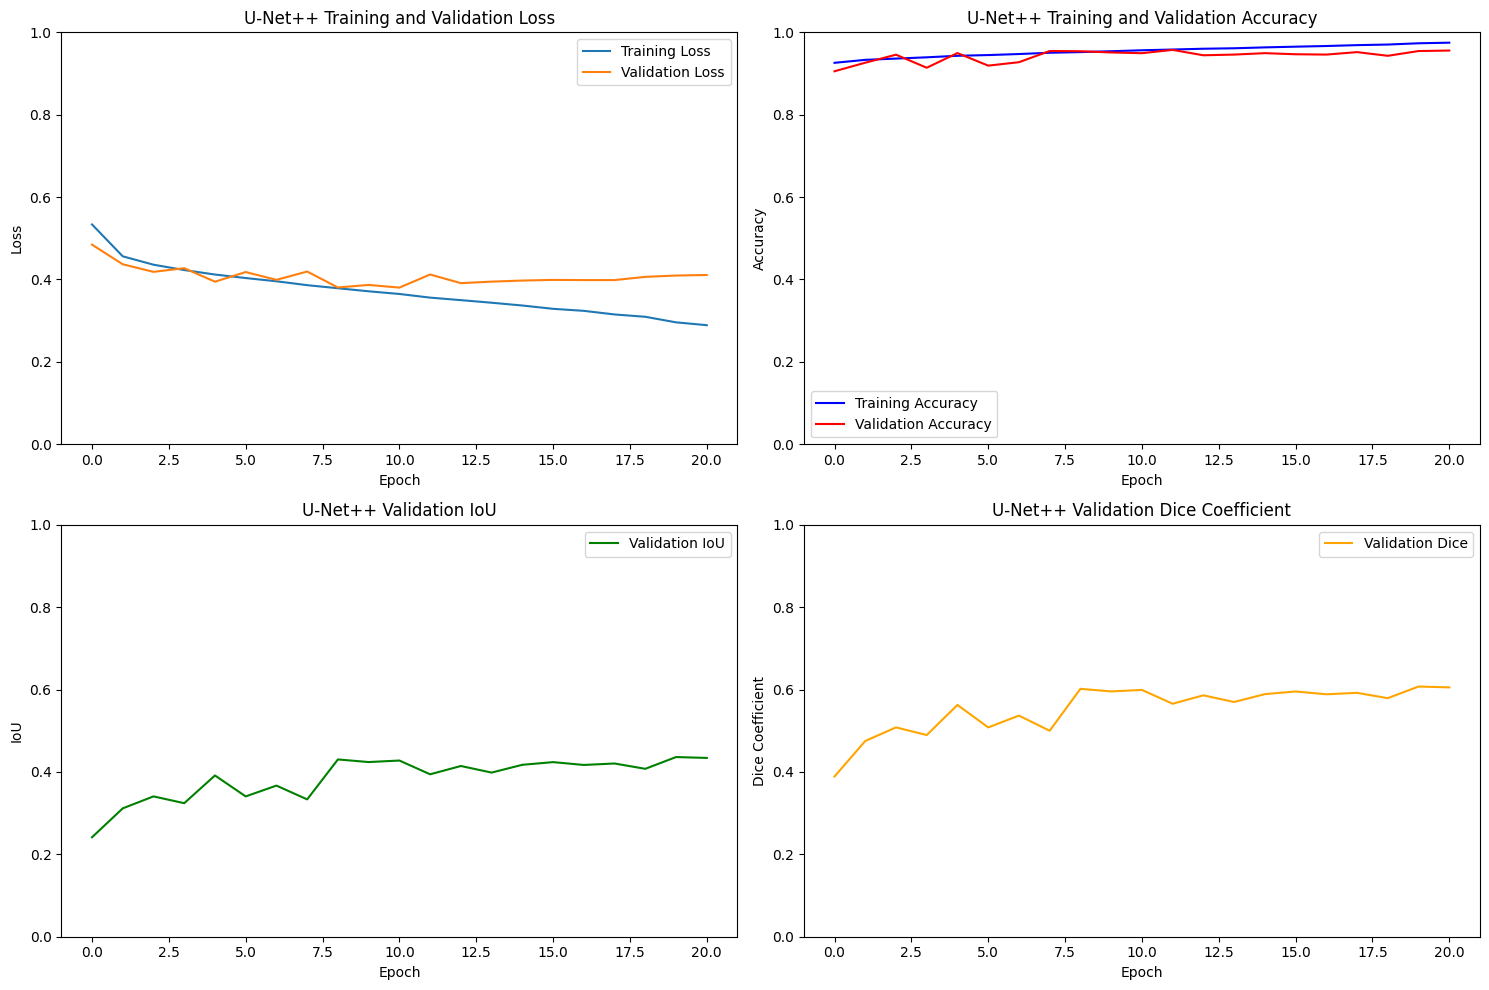

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim(0, 1)
ax1.legend()
ax1.set_title('U-Net++ Training and Validation Loss')

ax2.plot(train_accs, label='Training Accuracy', color='blue')
ax2.plot(val_accs, label='Validation Accuracy', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.set_title('U-Net++ Training and Validation Accuracy')

ax3.plot(val_ious, label='Validation IoU', color='green')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('IoU')
ax3.set_ylim(0, 1)
ax3.legend()
ax3.set_title('U-Net++ Validation IoU')

ax4.plot(val_dices, label='Validation Dice', color='orange')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Dice Coefficient')
ax4.set_ylim(0, 1)
ax4.legend()
ax4.set_title('U-Net++ Validation Dice Coefficient')

plt.tight_layout()
plt.savefig('unetpp_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## Test Evaluation

Loading best U-Net++ model for test evaluation...

Evaluating U-Net++ on test set...


Val batch: 100%|██████████| 332/332 [00:11<00:00, 29.80it/s]



U-NET++ TEST EVALUATION METRICS
Configuration: Matching SegFormer (lr=2e-4, dropout=0.15, threshold=0.5)
Test set processed with batch_size=1
Loss:            0.381235
IoU:             0.4264
mIoU:            0.6877
Dice Coefficient: 0.5978
Accuracy:        0.9508
Precision:       0.5809
Recall:          0.6158
F1-Score:        0.5978
Confusion matrix (pixel-level):
[[19892352   573889]
 [  496291   795420]]


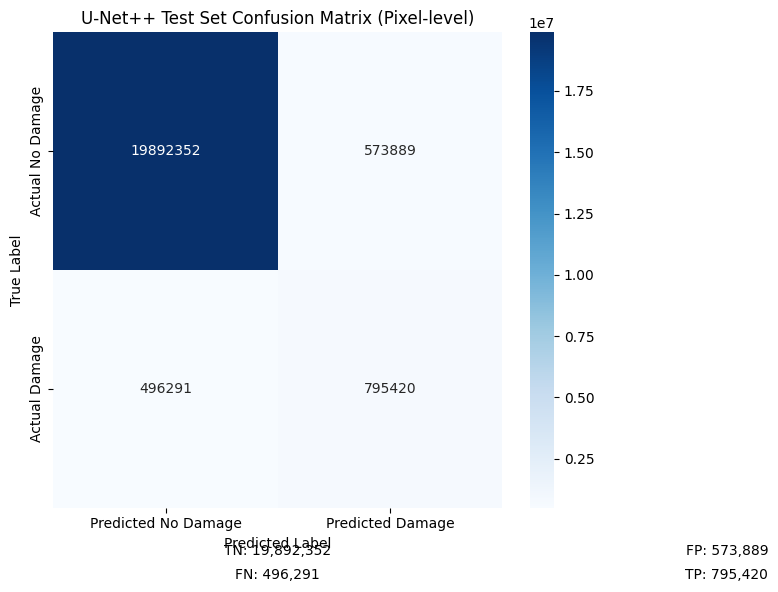

U-Net++ training and evaluation completed!


In [16]:
print("Loading best U-Net++ model for test evaluation...")
model.load_state_dict(torch.load('best_unetpp_earthquake.pth', map_location=device))
model.to(device)

print("\nEvaluating U-Net++ on test set...")
test_metrics = validate(model, test_loader)

print("\n" + "="*50)
print("U-NET++ TEST EVALUATION METRICS")
print("Configuration: Matching SegFormer (lr=2e-4, dropout=0.15, threshold=0.5)")
print("="*50)
print(f"Test set processed with batch_size=1")
print(f"Loss:            {test_metrics['loss']:.6f}")
print(f"IoU:             {test_metrics['iou']:.4f}")
print(f"mIoU:            {test_metrics['miou']:.4f}")
print(f"Dice Coefficient: {test_metrics['dice']:.4f}")
print(f"Accuracy:        {test_metrics['acc']:.4f}")
print(f"Precision:       {test_metrics['precision']:.4f}")
print(f"Recall:          {test_metrics['recall']:.4f}")
print(f"F1-Score:        {test_metrics['f1']:.4f}")
print("Confusion matrix (pixel-level):")
print(test_metrics["confusion"])
print("="*50)

plt.figure(figsize=(8, 6))
cm = test_metrics["confusion"]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted No Damage', 'Predicted Damage'],
            yticklabels=['Actual No Damage', 'Actual Damage'])
plt.title('U-Net++ Test Set Confusion Matrix (Pixel-level)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.text(0.5, -0.1, f'TN: {cm[0,0]:,}', ha='center', transform=plt.gca().transAxes)
plt.text(1.5, -0.1, f'FP: {cm[0,1]:,}', ha='center', transform=plt.gca().transAxes)
plt.text(0.5, -0.15, f'FN: {cm[1,0]:,}', ha='center', transform=plt.gca().transAxes)
plt.text(1.5, -0.15, f'TP: {cm[1,1]:,}', ha='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.savefig('unetpp_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("U-Net++ training and evaluation completed!")
